# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.



In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import time

Loading data

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.1MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.26MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.67MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Spliting training data in training and validation

In [3]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Making data set iterable

In [5]:
batch_size = 128
# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [6]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 128
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

Functions to train and evaluate

In [7]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [8]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

Training and evaluating base non linear classifier

In [9]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [10]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [11]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.7395823345184326, accuracy: 79.03333333333333
Epoch 0: val. loss: 0.7338983467284669, val. accuracy: 79.175
Epoch 1: training loss: 0.3935450582106908, accuracy: 88.7625
Epoch 1: val. loss: 0.38738703188743995, val. accuracy: 88.85833333333333
Epoch 2: training loss: 0.301062074581782, accuracy: 91.375
Epoch 2: val. loss: 0.29755702535522743, val. accuracy: 91.18333333333334
Epoch 3: training loss: 0.25206082634131116, accuracy: 92.74166666666666
Epoch 3: val. loss: 0.24989878116769992, val. accuracy: 92.66666666666666
Epoch 4: training loss: 0.21836512823899587, accuracy: 93.60833333333333
Epoch 4: val. loss: 0.2186908854290526, val. accuracy: 93.25833333333333
CPU times: user 55.3 s, sys: 131 ms, total: 55.4 s
Wall time: 57.5 s


Evaluate the model on test data

In [12]:
acc_test, loss_test = evaluate(test_dataloader, nonlinear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.2162, test accuracy: 93.41%


Trying different batch sizes

In [13]:
%%time

batch_size = {32, 64, 128, 256, 512} #
epochs = 5
df = pd.DataFrame({'N': range(1,epochs +1)})

for k in batch_size:

  train_dataloader = torch.utils.data.DataLoader(training_data, batch_size= k)
  val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size= k)

  nonlinear_model = NonlinearClassifier()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

  train_acc_all = []
  val_acc_all = []

  for j in range(epochs):

    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

  df['train_acc_'+ str(k)] = train_acc_all
  df['val_acc_'+ str(k)] = val_acc_all


Epoch 0: training loss: 0.26678604547555246, accuracy: 92.34583333333333
Epoch 0: val. loss: 0.26045400082071624, val. accuracy: 92.11666666666667
Epoch 1: training loss: 0.16921655371971428, accuracy: 95.09791666666668
Epoch 1: val. loss: 0.1697160162826379, val. accuracy: 95.025
Epoch 2: training loss: 0.13189899663285662, accuracy: 96.1625
Epoch 2: val. loss: 0.1424642964179317, val. accuracy: 95.86666666666666
Epoch 3: training loss: 0.11775759555771947, accuracy: 96.50625000000001
Epoch 3: val. loss: 0.13292712304368615, val. accuracy: 96.04166666666667
Epoch 4: training loss: 0.10022560791686798, accuracy: 97.11874999999999
Epoch 4: val. loss: 0.11975842642659942, val. accuracy: 96.55833333333334
Epoch 0: training loss: 1.9618840363431485, accuracy: 34.014583333333334
Epoch 0: val. loss: 1.9599870062888938, val. accuracy: 34.425
Epoch 1: training loss: 0.8030296310465387, accuracy: 74.14791666666667
Epoch 1: val. loss: 0.7999332407687573, val. accuracy: 73.78333333333333
Epoch 2:

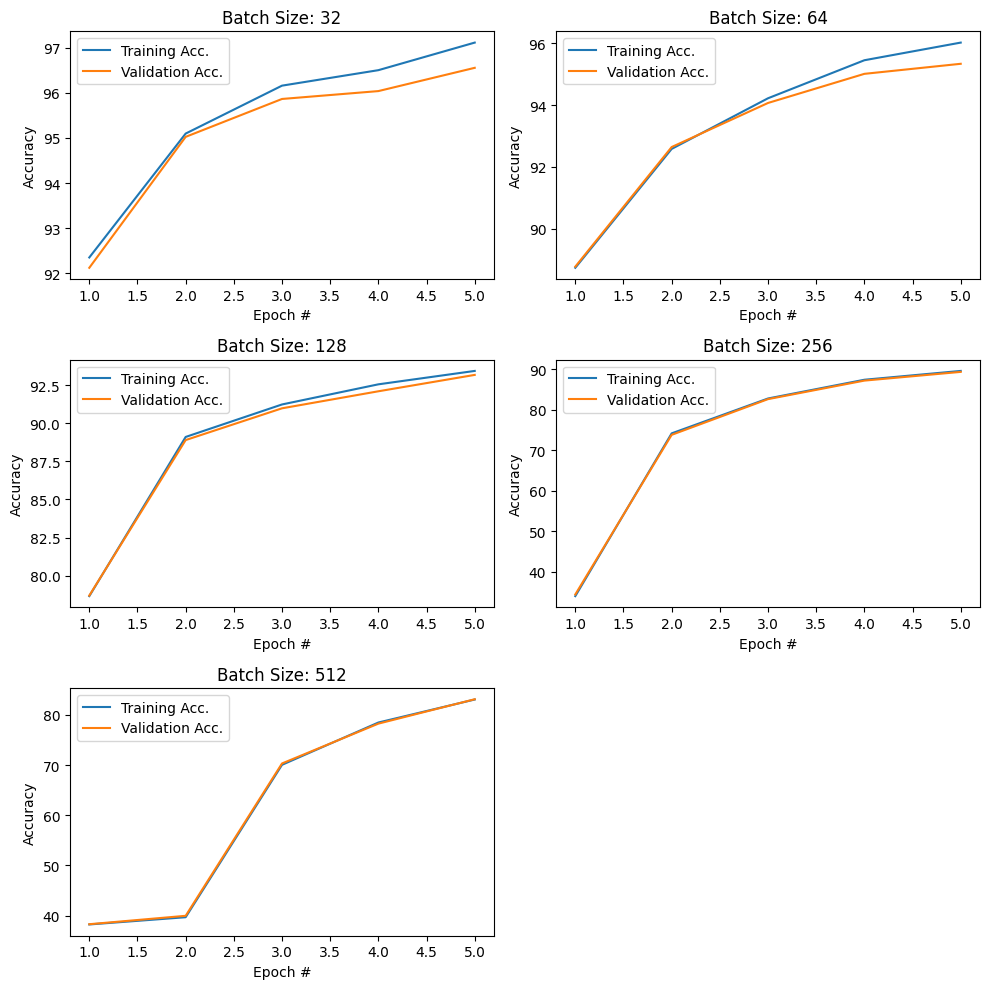

In [20]:
pltsize = 1
fig, axes = plt.subplots(3, 2, figsize=(10 * pltsize, 10 * pltsize))

batch_sizes = [32, 64, 128, 256, 512]
axes_flat = axes.flatten()  # Flatten axes for easier iteration

for i, batch_size in enumerate(batch_sizes):
    ax = axes_flat[i]  # Get the current axes
    ax.plot(df['N'], df['train_acc_' + str(batch_size)], label='Training Acc.')
    ax.plot(df['N'], df['val_acc_' + str(batch_size)], label='Validation Acc.')
    ax.set_xlabel('Epoch #')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.set_title(f'Batch Size: {batch_size}')  # Add title for clarity

# Hide any unused subplots
if len(batch_sizes) < len(axes_flat):
    for j in range(len(batch_sizes), len(axes_flat)):
        axes_flat[j].set_visible(False)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Variable              Type                   Data/Info
------------------------------------------------------
NonlinearClassifier   type                   <class '__main__.NonlinearClassifier'>
acc                   float                  83.06666666666666
acc_test              float                  93.41000000000001
ax                    Axes                   Axes(0.0750278,0.0582778;0.423972x0.247722)
axes                  ndarray                3x2: 6 elems, type `object`, 48 bytes
axes_flat             ndarray                6: 6 elems, type `object`, 48 bytes
batch_size            int                    512
batch_size_test       int                    128
batch_sizes           list                   n=5
df                    DataFrame                 N  train_acc_32  val_a<...> 83.066667    83.116667  
epochs                int                    5
evaluate              function               <function evaluate at 0x7c7c40ef5b40>
fig                   Figure                 Figu

2. Bonus: What is a learning rate scheduler?